In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

import optuna
from optuna.samplers import TPESampler

def plot_AUC(y_real, predictions):
    AUC_PR_mean = []
    AUC_ROC_mean = []
    for y_r, y_p in zip(y_real, predictions):
        
        positive = y_r.sum()
        
        plt.figure(figsize=(16, 8))

        plt.subplot(121)
        precision, recall, thresholds = precision_recall_curve(y_r, y_p)
        plt.plot(recall, precision, lw = 1.5, label='PR curve')
        plt.axhline(positive/y_r.shape[0], 0, 1, linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PR curve')
        plt.legend(['LightGBM', 'Random Classifier'])
        plt.grid()

        AUC_PR = auc(recall, precision)

        plt.subplot(122)
        fpr, tpr, thresholds = roc_curve(y_r, y_p)
        plt.plot(fpr, tpr, lw=1.5, label='ROC curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(['LightGBM', 'Random Classifier'])

        AUC_ROC = auc(fpr, tpr)
        
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        print('AUC-PR - {}'.format(round(AUC_PR, 5)))
        print('AUC-ROC - {}'.format(round(AUC_ROC, 5)))
        
        AUC_PR_mean.append(AUC_PR)
        AUC_ROC_mean.append(AUC_ROC)
    
    print('MEAN AUC-PR - {}'.format(round(np.array(AUC_PR_mean).mean(), 5)))
    print('MEAN AUC-ROC - {}'.format(round(np.array(AUC_ROC_mean).mean(), 5)))
    
    
def print_results(study):
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  AUC_ROC: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# 0. Обработка сырых данных

In [3]:
# with gzip.open('accepted_2007_to_2018Q4.csv.gz', 'rb') as f:
#     accepted = pd.read_csv(f)

Сразу удалим топ N признаков, имеющих наибольшее количество пропусков (более 50 тыс.).

In [ ]:
accepted_nulls = accepted.isnull().sum().sort_values(ascending=False)
cols_to_drop = accepted_nulls[accepted_nulls > 50000].index
accepted = accepted.drop(columns=cols_to_drop)

Описание признаков можно найти здесь  https://rstudio-pubs-static.s3.amazonaws.com/115829_32417d32dbce41eab3eeaf608a0eef9d.html

или здесь https://github.com/dosei1/Lending-Club-Loan-Data/blob/master/LCDataDictionary.csv

Удалим дополнительно признаки, которые не несут смысла для модели (или очень сложно использовать) и в которых возможен лик

In [ ]:
col_drop = ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec',
           'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
            'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
            'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
            'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
           'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'hardship_flag', 'debt_settlement_flag']

In [ ]:
accepted = accepted.drop(columns=col_drop)

Описание признаков:
1. id - id клиента
1. loan_amnt - сумма долга (сильно скорелирован с funded_amnt и funded_amnt_inv)
1. term - срок кредита
1. int_rate - % ставка кредита
1. installment - ежемесячный платеж 
1. grade - кредитный рейтинг заемщика (должна проставляться до выдачи кредита, те. можно использовать)
1. sub_grade - подгруппа кредитного рейтинг 
1. home_ownership - тип жилья клиента 
1. annual_inc - годовой доход клиента 
1. verification_status - статус дохода клиента (подтвержден или нет)
1. issue_d - дата выдачи кредита
1. loan_status	- статус заявки (наша целевая переменная)
1. purpose - на что взят кредит 
1. title - подкатегория взятия кредита
1. zip_code - почтовый индекс
1. addr_state - штат клиента
1. dti - Debt-to-income ratio, долг к доходу
1. earliest_cr_line - The date the borrower's earliest reported (дата первого кредита)
1. fico_range_low - нижнее значение кредитного рейтинга ФИКО
1. fico_range_high - верхнее значение кредитного рейтинга ФИКО
1. open_acc - Количество открытых кредитных линий в кредитное досье заемщика.
1. total_acc - Общее количество кредитных линий в досье заемщика
1. policy_code - код продукта (общедоступность продукта)
1. application_type - тип заема (индивидуальный или в группе)
1. pub_rec_bankruptcies - количество несостоятельностей клиента (вроде можно использовать, но может быть и лик)
1. tax_liens - количество налогового залога
1. disbursement_method - как были выданы деньги

# Предобработка признаков

Оставим только то, что будем предсказывать:
- Fully Paid - Кредит полностью выплачен
- Charged Off,  Does not meet the credit policy. Status:Charged Off, Default - дефолт

In [ ]:
accepted = accepted[accepted.loan_status.isin(['Fully Paid', 'Charged Off', 'Default',
       'Does not meet the credit policy. Status:Charged Off'])]
accepted.loan_status = accepted.loan_status.apply(lambda x: 0 if x =='Fully Paid' else 1)

Приведение признаков к нормальной форме:

In [ ]:
accepted.id = accepted.id.astype(np.int64)
accepted.term = accepted.term.apply(lambda x: x[0:3]).astype(int)

grades = sorted(accepted.grade.unique())
grades = {k:v for v, k in enumerate(grades)}
accepted.grade = accepted.grade.map(grades)

grades = sorted(accepted.sub_grade.unique())
grades = {k:v for v, k in enumerate(grades)}
accepted.sub_grade = accepted.sub_grade.map(grades)

zip_code = accepted.zip_code.value_counts().head(50).index
accepted.zip_code = accepted.zip_code.apply(lambda x: x[:3] if x in zip_code else 0).astype(int)

accepted.earliest_cr_line = accepted.earliest_cr_line.astype(np.datetime64)
accepted.issue_d = accepted.issue_d.astype(np.datetime64)

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 
        
    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
    
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state', 'application_type', 'disbursement_method']   
accepted = MultiColumnLabelEncoder(columns = cat).fit_transform(accepted)

In [ ]:
accepted = accepted.sort_values(by='issue_d')

#### Заполнение пропусков

In [ ]:
accepted.dti.fillna(accepted.dti.mean(), inplace = True)
accepted['earliest_cr_before_this'] = (accepted.issue_d  - accepted.earliest_cr_line)
accepted.earliest_cr_before_this = accepted.earliest_cr_before_this.apply(lambda x: x.days).fillna(0)
accepted = accepted.drop(['earliest_cr_line'], axis=1)
accepted.total_acc.fillna(0, inplace = True)
accepted.pub_rec_bankruptcies.fillna(0, inplace = True)
accepted.tax_liens.fillna(0, inplace = True)
accepted.open_acc.fillna(0, inplace = True)
accepted.policy_code.fillna(0, inplace = True)

In [ ]:
accepted.to_csv('accepted.csv', index=False)

# 1. Обработка данных для логистической регрессии

In [3]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])

#### OHE

In [4]:
OHE_cat = ['home_ownership', 'verification_status', 'purpose', 'addr_state']   

enc = OneHotEncoder(drop='first', sparse=False)
for OHE in OHE_cat:
    col = enc.fit_transform(df[OHE].values.reshape(-1, 1))
    hot_col = pd.DataFrame(col, columns=[OHE + '_' + str(i) for i in range(col.shape[1])])
    df = pd.concat([df, hot_col], axis=1)

#### Выделим обучающую, валидационную и тестовую часть

In [5]:
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop('issue_d', axis=1)
train = df[df.issue_d < np.datetime64('2017-01-01')].drop('issue_d', axis=1)
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

In [6]:
train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

In [7]:
X_train, X_val = X.loc[train_inx], X.loc[val_inx]
X_global_train = pd.concat([X_train, X_val], ignore_index=True)
y_train, y_val = y.loc[train_inx], y.loc[val_inx]
y_global_train = pd.concat([y_train, y_val], ignore_index=True)

## Запишем результаты

In [15]:
pos = y_global_train.sum() / y_global_train.shape[0] 
neg = (y_global_train.shape[0] - y_global_train.sum()) / y_global_train.shape[0]

results = pd.DataFrame({'random_classifier': [0.5, 0.5, pos, 0.5, 0.5, neg**2+pos**2]})

results.index = ['Precision', 'Recall', 'AUC-PR', 'AUC-ROC', 'F1_score', 'Accuracy']

### Логистическая регрессия

In [11]:
# sampler=TPESampler(seed=10)

# def objective_LR(trial):
#     tol = trial.suggest_uniform('tol ', 1e-5, 1e-3)
#     C = trial.suggest_uniform('C', 0.01, 1)
    
#     LR = LogisticRegression(tol=tol, C=C, max_iter=1000, n_jobs=-1, random_state=77, class_weight='balanced')
#     LR.fit(X_train, y_train)
#     preds = LR.predict_proba(X_val)[:,1]
#     ROC_AUC = roc_auc_score(y_val, preds)
#     return ROC_AUC

# study_lr = optuna.create_study(direction="maximize", sampler=sampler)
# study_lr.optimize(objective_LR, n_trials=100, timeout=None, n_jobs=-1)

In [10]:
# print_results(study_lr)

Number of finished trials: 89
Best trial:
  AUC_ROC: 0.6010318992372939
  Params: 
    tol : 0.0009632639105524963
    C: 0.211577427610677


              precision    recall  f1-score   support

           0       0.85      0.17      0.28    177596
           1       0.23      0.90      0.36     48043

    accuracy                           0.32    225639
   macro avg       0.54      0.53      0.32    225639
weighted avg       0.72      0.32      0.30    225639



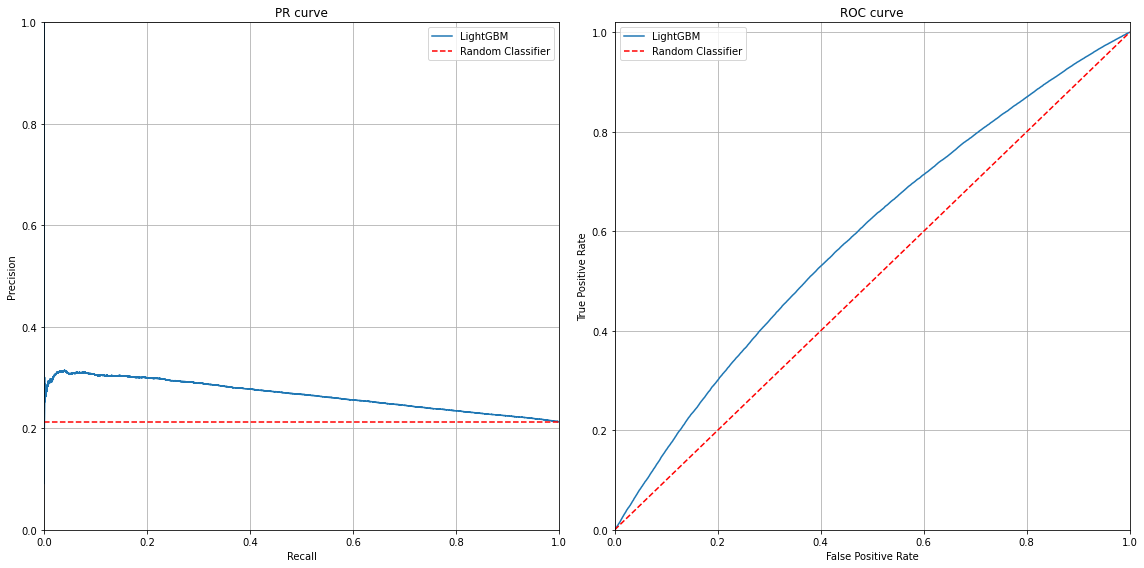

AUC-PR - 0.26569
AUC-ROC - 0.58665
MEAN AUC-PR - 0.26569
MEAN AUC-ROC - 0.58665


In [12]:
LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
LR.fit(X_global_train, y_global_train)
preds = LR.predict_proba(X_test)[:,1]
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_test, preds_0_1, average='macro')
recall = recall_score(y_test, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_test, preds)
AUC_ROC = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds_0_1, average='macro')
accuracy = accuracy_score(y_test, preds_0_1)
results['Log_Reg'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

print(classification_report(y_test, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_test], [preds])

# 2. LightGBM

In [11]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state', 'application_type', 'disbursement_method']   

In [12]:
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop('issue_d', axis=1)
train = df[df.issue_d < np.datetime64('2017-01-01')].drop('issue_d', axis=1)
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

X_train, X_val = X.loc[train_inx], X.loc[val_inx]
X_global_train = pd.concat([X_train, X_val], ignore_index=True)
y_train, y_val = y.loc[train_inx], y.loc[val_inx]
y_global_train = pd.concat([y_train, y_val], ignore_index=True)

In [13]:
dtrain_global = lgb.Dataset(X_global_train, label=y_global_train, categorical_feature=cat, free_raw_data=False)
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat, free_raw_data=False)

In [7]:
# sampler=TPESampler(seed=10)

# def objective_lgb(trial):    
#     param = {'num_leaves': trial.suggest_int('num_leaves', 2, 100),
#           'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
#           'objective': 'binary',
#           'max_depth': trial.suggest_int('max_depth', 5, 100),
#           'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.4),
#           "boosting_type": "gbdt",
#           "metric": 'auc',
#           'reg_alpha': trial.suggest_uniform('reg_alpha', 0.01, 0.4),
#           'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.4),
#          'is_unbalance': True}
    
#     gbm = lgb.train(param, dtrain, verbose_eval=False, num_boost_round=1000)
#     preds = gbm.predict(X_val)
#     ROC_AUC = roc_auc_score(y_val, preds)
#     return ROC_AUC

# study_lgb = optuna.create_study(direction="maximize", sampler=sampler)
# study_lgb.optimize(objective_lgb, n_trials=100, timeout=None, n_jobs=2)

[I 2021-06-06 21:31:13,970] A new study created in memory with name: no-name-54d51eec-fde8-4f29-b19b-03e19d36dc12
[I 2021-06-06 21:32:56,781] Trial 0 finished with value: 0.6893383753944304 and parameters: {'num_leaves': 35, 'min_child_samples': 49, 'max_depth': 88, 'learning_rate': 0.19611516302280074, 'reg_alpha': 0.07745207048000578, 'reg_lambda': 0.2270810253309193}. Best is trial 0 with value: 0.6893383753944304.
[I 2021-06-06 21:33:16,061] Trial 1 finished with value: 0.7020974152999314 and parameters: {'num_leaves': 32, 'min_child_samples': 37, 'max_depth': 31, 'learning_rate': 0.09943457503336395, 'reg_alpha': 0.32796079995341254, 'reg_lambda': 0.06297452237251017}. Best is trial 1 with value: 0.7020974152999314.
[I 2021-06-06 21:35:34,560] Trial 2 finished with value: 0.7145705456784679 and parameters: {'num_leaves': 94, 'min_child_samples': 8, 'max_depth': 32, 'learning_rate': 0.019000677791726275, 'reg_alpha': 0.24498015737069234, 'reg_lambda': 0.17768748573116006}. Best is 

[I 2021-06-06 21:58:51,178] Trial 26 finished with value: 0.7157981930375562 and parameters: {'num_leaves': 72, 'min_child_samples': 25, 'max_depth': 43, 'learning_rate': 0.013560024069282941, 'reg_alpha': 0.17425305285197618, 'reg_lambda': 0.39734201679709347}. Best is trial 26 with value: 0.7157981930375562.
[I 2021-06-06 21:59:31,499] Trial 27 finished with value: 0.6974391997952228 and parameters: {'num_leaves': 73, 'min_child_samples': 1, 'max_depth': 43, 'learning_rate': 0.06592230133434238, 'reg_alpha': 0.1638845681608888, 'reg_lambda': 0.3958322480100066}. Best is trial 26 with value: 0.7157981930375562.
[I 2021-06-06 22:01:42,343] Trial 29 finished with value: 0.6909407511594332 and parameters: {'num_leaves': 66, 'min_child_samples': 60, 'max_depth': 22, 'learning_rate': 0.10802972320977539, 'reg_alpha': 0.1260032132430416, 'reg_lambda': 0.39841941069857706}. Best is trial 26 with value: 0.7157981930375562.
[I 2021-06-06 22:02:08,813] Trial 28 finished with value: 0.7033949830

[I 2021-06-06 22:39:36,663] Trial 51 finished with value: 0.7159911253985982 and parameters: {'num_leaves': 89, 'min_child_samples': 54, 'max_depth': 18, 'learning_rate': 0.010851446085216413, 'reg_alpha': 0.2178496781793919, 'reg_lambda': 0.09289691649792249}. Best is trial 42 with value: 0.716141680946458.


KeyboardInterrupt: 

In [ ]:
# print_results(study_lgb)

С тюнингом

In [17]:
param = {'num_leaves': 89,
      'min_child_samples': 29,
      'objective': 'binary',
      'max_depth': 21,
      'learning_rate': 0.012,
      "boosting_type": "gbdt",
      "metric": 'auc',
      'reg_alpha': 0.22,
      'reg_lambda': 0.2,
     'is_unbalance': True,
         'verbose': -1}

gbm = lgb.train(param, dtrain_global, num_boost_round=1000)
preds = gbm.predict(X_test)
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_test, preds_0_1, average='macro')
recall = recall_score(y_test, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_test, preds)
AUC_ROC = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds_0_1, average='macro')
accuracy = accuracy_score(y_test, preds_0_1)
results['LightGBM'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

In [18]:
results

,random_classifier,LightGBM
Precision,0.500000,0.604119
Recall,0.500000,0.655288
AUC-PR,0.197521,0.394129
AUC-ROC,0.500000,0.716128
F1_score,0.500000,0.571163
Accuracy,0.682987,0.608357


              precision    recall  f1-score   support

           0       0.89      0.57      0.70    177596
           1       0.32      0.74      0.44     48043

    accuracy                           0.61    225639
   macro avg       0.60      0.66      0.57    225639
weighted avg       0.77      0.61      0.64    225639



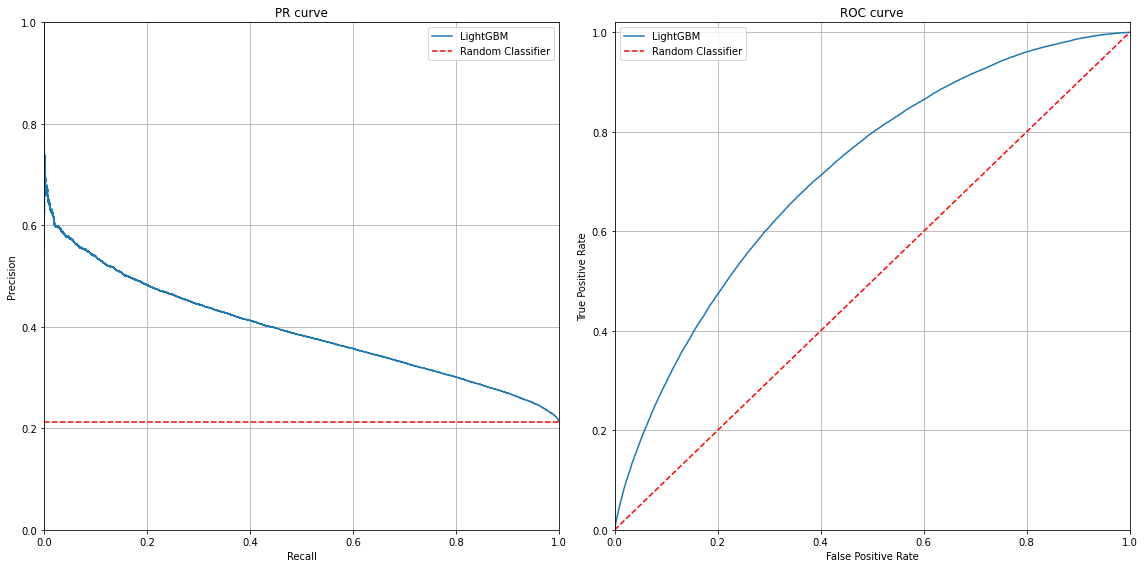

AUC-PR - 0.39411
AUC-ROC - 0.71613
MEAN AUC-PR - 0.39411
MEAN AUC-ROC - 0.71613


In [19]:
print(classification_report(y_test, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_test], [preds])

# важность признаков

In [20]:
feature = pd.DataFrame({
    'feature_name': X_train.columns,
    'importance': gbm.feature_importance('gain')
})

feature_sorted = feature.sort_values(by='importance', ascending=False)

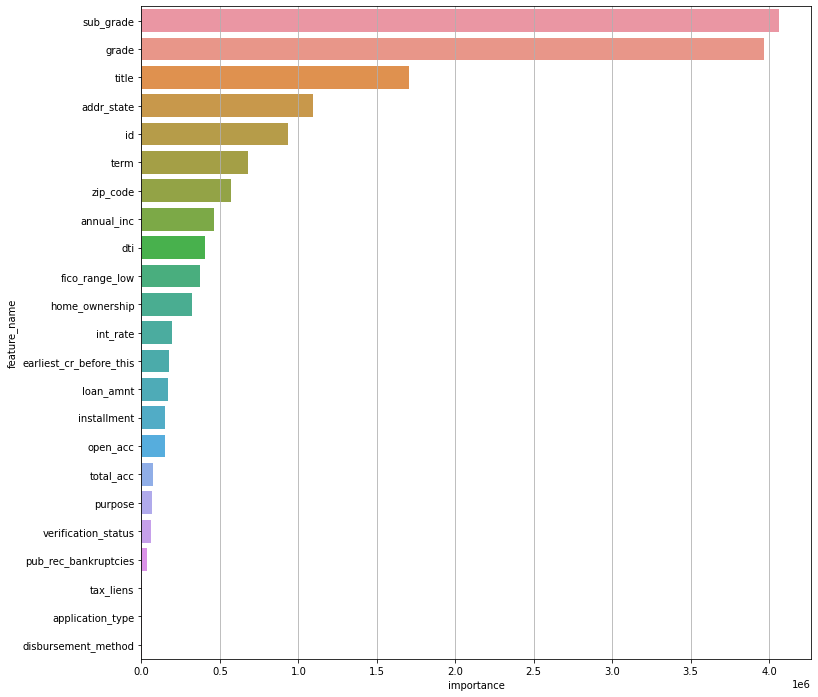

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.grid()
sns.barplot(x="importance", y="feature_name", data=feature_sorted[feature_sorted.importance != 0])

plt.show()